# Calibration

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z  in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

#data path
cal1_path="/home/ema/Uni/LCP/LCPa_Project/180904/Run000263/data_000000.txt"

#best detectors configuration for a given run ([2,3] or [0,1]?)
calib_config=[0,1]

In [3]:
cal1={}
false_events_counter=0
with open(cal1_path) as cal1_file:
    for line in cal1_file:
        row=line.strip().split()
        key=int(row[0])
        n_hits=int(row[1])
        if n_hits!=0:
            data_array=np.array(row[2:]).reshape((n_hits, 5))
            data_dict={}
            columns=['chamber', 'layer', 'xleft', 'xright', 'time']
            for i in range(2):
                data_dict[columns[i]]=data_array[:, i].astype(int)
            for i in range(2,5):
                data_dict[columns[i]]=data_array[:, i].astype(float)
            value=pd.DataFrame(data_dict)
            cal1[key]=value
        else:
            false_events_counter+=1
original_data_length=len(cal1)+false_events_counter
print(f"null over nonnull events ratio (%) : {false_events_counter/(len(cal1)+false_events_counter)*100}%")

null over nonnull events ratio (%) : 63.24900133155792%


In [4]:
for event in cal1.values():
    event['xrg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xleft'], axis=1)
    event['xlg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xright'], axis=1)
    event['zg']=event.apply(lambda df: global_z_shifts[int(df['chamber'])]-local_z_shifts[int(df['layer'])-1]+4*ZCELL-ZCELL/2, axis=1)
    event['valid_layer']=pd.Series(np.ones(len(event)).astype(bool))

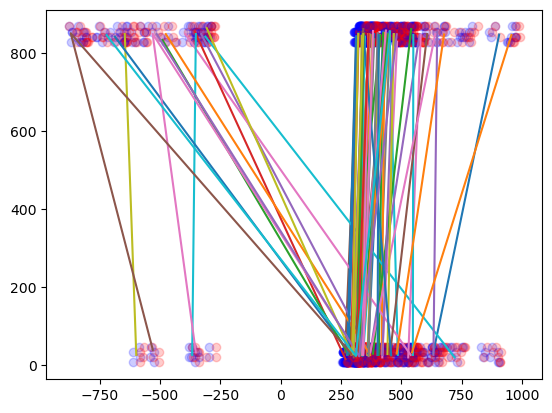

In [5]:
fig, ax=plt.subplots()
count=0
for event in cal1.values():
    ax.scatter(event['xlg'], event['zg'], color='blue', alpha=0.2)
    ax.scatter(event['xrg'], event['zg'], color='red', alpha=0.2)
    ax.plot((event.groupby('chamber').mean().reset_index()['xlg']+event.groupby('chamber').mean().reset_index()['xlg'])/2, event.groupby('chamber').mean().reset_index()['zg'], '-')
    count+=1
    if(count>=100):
        break
#ax.set_xlim(-450, -405)
plt.show()

[(347, '[0, 1]'), (64, '[2, 3]'), (53, '[1]'), (25, '[0, 1, 2]'), (17, '[2]'), (12, '[1, 2]'), (12, '[0]'), (11, '[3]'), (5, '[0, 1, 3]'), (3, '[0, 1, 2, 3]'), (1, '[1, 2, 3]'), (1, '[0, 2]'), (1, '[0, 2, 3]')]
('[0, 1]', '[2, 3]', '[1]', '[0, 1, 2]', '[2]', '[1, 2]', '[0]', '[3]', '[0, 1, 3]', '[0, 1, 2, 3]', '[1, 2, 3]', '[0, 2]', '[0, 2, 3]') (347, 64, 53, 25, 17, 12, 12, 11, 5, 3, 1, 1, 1)


Text(0.5, 1.0, 'number of events for any combination of triggered chambers')

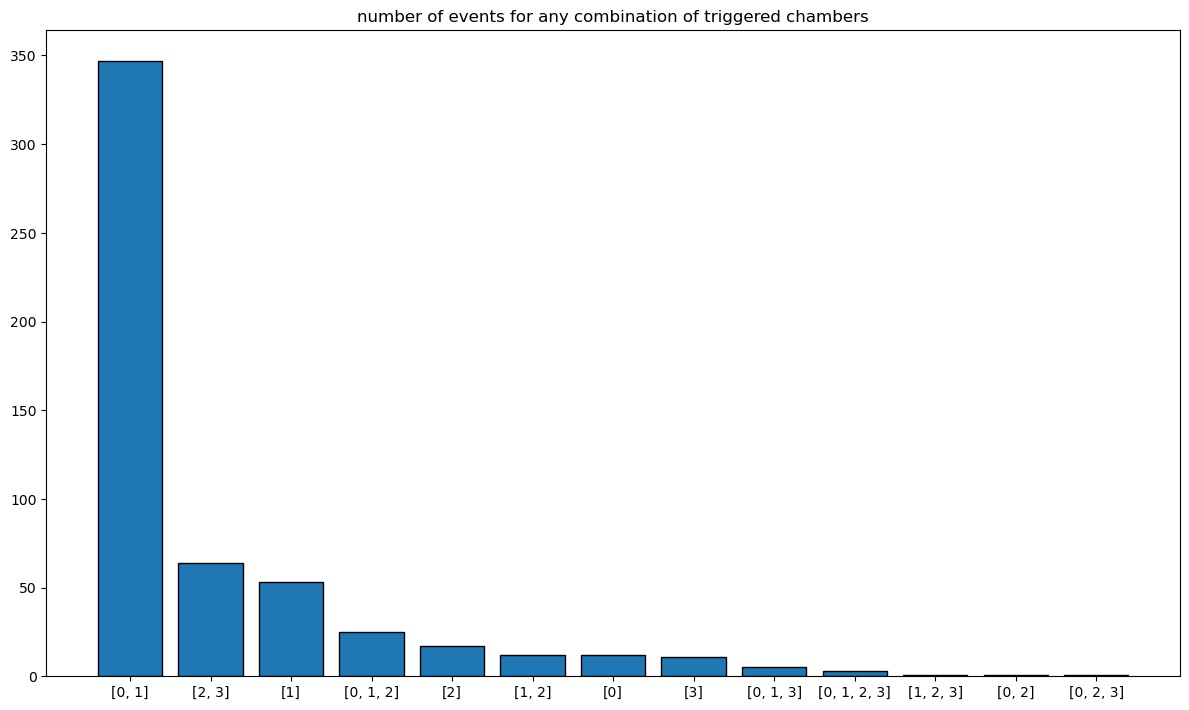

In [6]:
fig,ax=plt.subplots(figsize=(12,7))
bins, counts=(np.unique([str(sorted(np.unique(event['chamber']))) for event in cal1.values()], return_counts=True))
zipped=zip(counts, bins)
sortedzipped=sorted(zipped, reverse=True)
print(sortedzipped)
[counts, bins]=zip(*sortedzipped)
print(bins, counts)
ax.bar(bins, counts, edgecolor='black')
fig.tight_layout()
ax.set_title('number of events for any combination of triggered chambers')

8.590778097982708
8



Text(0.5, 1.0, 'number of events vs number of hits for the calib_config chambers events')

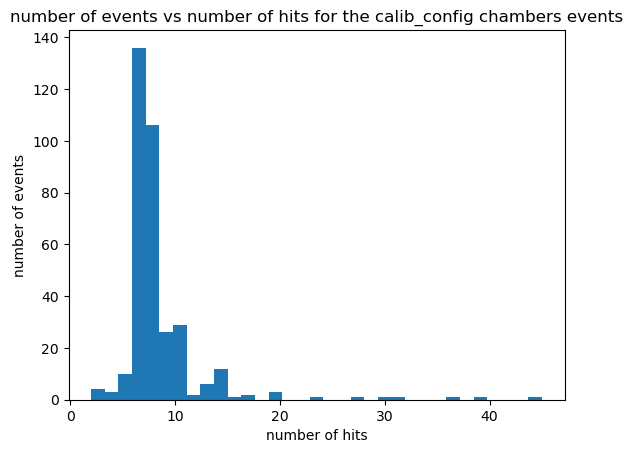

In [7]:
n_hits_per_event=[len(event) for event in cal1.values() if sorted(np.unique(event['chamber']))==calib_config]
print(np.mean(n_hits_per_event))
print(np.unique(n_hits_per_event)[np.argmax(np.unique(n_hits_per_event, return_counts=True)[1])])
plt.hist(n_hits_per_event, bins=33)
print()
plt.xlabel('number of hits')
plt.ylabel('number of events')
plt.title('number of events vs number of hits for the calib_config chambers events')

In [8]:
'''
print(not np.any(np.array(cal1[4].groupby('chamber').count().reset_index()['layer']<3)))
print(cal1[4])
'''

"\nprint(not np.any(np.array(cal1[4].groupby('chamber').count().reset_index()['layer']<3)))\nprint(cal1[4])\n"

In [14]:
def desired_chamber_config(event):
    return sorted(np.unique(event['chamber']))==calib_config

def three_layers_per_det_filter(event):
    return not np.any(event[event['valid_layer']==True].groupby('chamber')['layer'].nunique().reset_index()['layer']<3)

def one_hit_per_layer(event):
    return not np.any(event.groupby(['chamber', 'layer']).count().reset_index()['time']!=1)

outofedge_counter=0
for event in cal1.values():
    row_indexer=event[np.abs(event['xleft']-event['xright'])>XCELL].index
    event.loc[row_indexer,'valid_layer'] = False
    #event[np.abs(event['xleft']-event['xright'])>XCELL]['valid_layer']=False
    if (len(row_indexer)>0):
        outofedge_counter+=1
print(f" \'out of cell edge\' event ratio {outofedge_counter/len(cal1)}")

impeccable_events=list(filter(lambda key : desired_chamber_config(cal1[key]) and three_layers_per_det_filter(cal1[key]) and one_hit_per_layer(cal1[key]), cal1))
print(impeccable_events)
print(f"ratio between events in [2-3] config and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between events in [2-3] config and original dataset events {len(impeccable_events)/original_data_length}")

 'out of cell edge' event ratio 0.012681159420289856
[3, 7, 10, 11, 17, 19, 26, 35, 47, 50, 53, 65, 66, 70, 73, 78, 89, 90, 97, 100, 105, 113, 116, 118, 122, 123, 124, 138, 139, 145, 179, 181, 186, 188, 189, 195, 206, 214, 226, 232, 253, 257, 281, 283, 285, 286, 289, 291, 293, 299, 302, 307, 317, 319, 329, 337, 339, 344, 345, 349, 351, 353, 372, 374, 381, 387, 389, 393, 398, 401, 404, 405, 411, 415, 416, 417, 419, 429, 430, 442, 443, 444, 445, 447, 449, 454, 460, 462, 467, 473, 475, 481, 484, 486, 489, 490, 499, 509, 514, 530, 532, 535, 543, 552, 560, 580, 587, 588, 600, 626, 633, 636, 646, 663, 681, 701, 758, 770, 776, 785, 808, 827, 831, 836, 839, 854, 869, 879, 881, 918, 919, 936, 942, 965, 978, 979, 987, 990, 997, 998, 1015, 1019, 1050, 1052, 1073, 1087, 1093, 1117, 1146, 1162, 1165, 1188, 1214, 1216, 1227, 1231, 1237, 1252, 1258, 1265, 1270, 1284, 1285, 1294, 1306, 1331, 1336, 1337, 1374, 1409, 1443, 1455, 1458, 1465, 1470, 1479, 1485, 1492, 1493, 1503, 1506, 1522, 1530, 1534, 156

In [15]:
print(cal1[2].groupby('chamber')['layer'].nunique().reset_index())
print(cal1[2])

   chamber  layer
0        0      2
1        1      4
   chamber  layer  xleft  xright   time    xrg    xlg     zg  valid_layer
0        0      2  664.5   679.5  139.0  329.7  314.7  856.0         True
1        0      4  663.3   680.7  162.0  330.9  313.5  830.0         True
2        1      1  638.1   663.9  240.0  309.3  283.5   45.5         True
3        1      2  664.9   679.1  132.0  282.5  268.3   32.5         True
4        1      3  636.8   665.2  263.0  310.6  282.2   19.5         True
5        1      4  666.5   677.5  102.0  280.9  269.9    6.5         True


In [16]:
from itertools import product
from scipy.stats import pearsonr
from math import atan2


def angle(A,B, C=None):
    #takes two points A and B with coordinates A=(xA,yA)... and return the angle on the plane in radiants
    #OR takes three points A, B, C with coordinates A=(xA,yA).. and return the difference angle BC^-AB^
    if C==None:
        return np.pi/2-atan2(A[1]-B[1], A[0]-B[0])
    else:
        return angle(B,C)-angle(A,B)

def zigzaginess(path):
    if(len(path)>=3):
        squaresum=0
        for i in range(len(path)-2):
            A=path[i]
            B=path[i+1]
            C=path[i+2]
            squaresum+=(angle(A,B,C))**2
        return squaresum
    else:
        print("Error: path of less than 3 points")
        return "error"

def opt_track(event, chamber):
    single_chamber=event[event['chamber']==chamber][event['valid_layer']==True]
    single_chamber=single_chamber.sort_values(by='zg')
    axes=[['xrg', 'xlg']]*len(single_chamber)
    xcs=list(product(*axes))
    paths=[[(np.array(single_chamber[xc[i]])[i], np.array(single_chamber['zg'])[i] ) for i in range(len(single_chamber))] for xc in xcs]
    #sorting_function=(lambda path : abs(pearsonr(*zip(*path)).pvalue))
    #sorting_function=(lambda path : abs(np.corrcoef(*zip(*path))[0,1]))
    straightness_function=lambda x: -zigzaginess(x)
    best_path=max(paths, key=straightness_function)
    return best_path

/tmp/ipykernel_23960/3790509124.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_layer']==True]


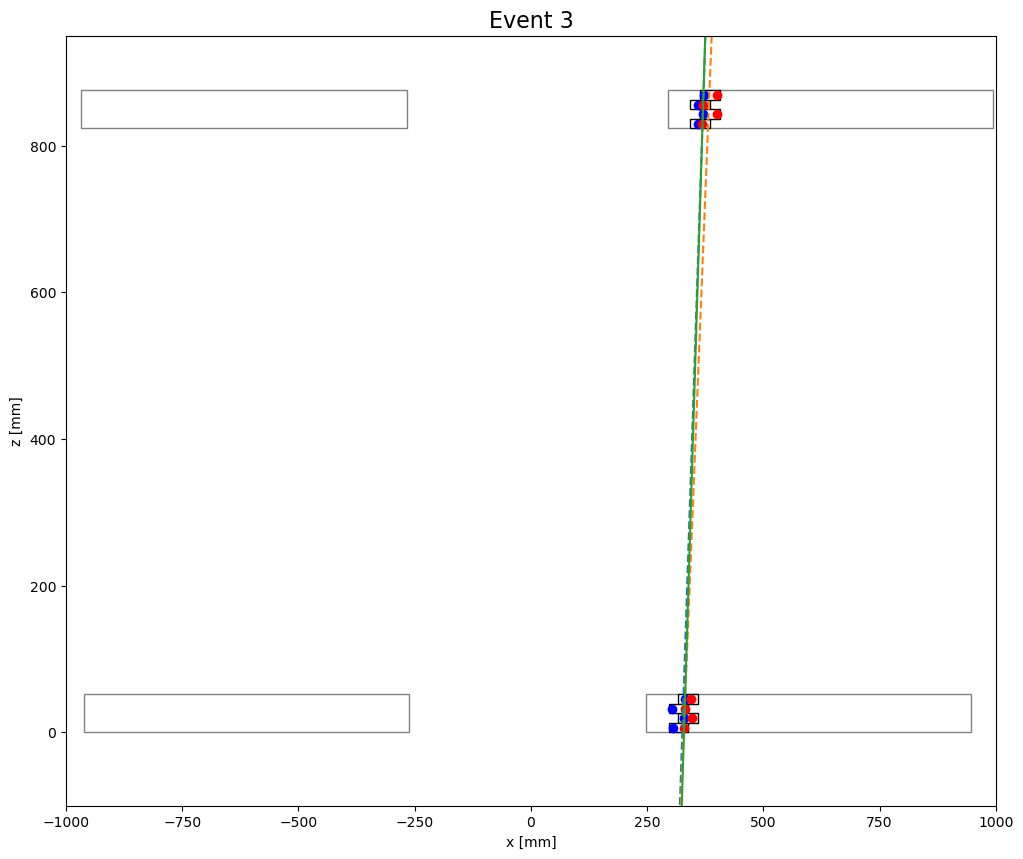

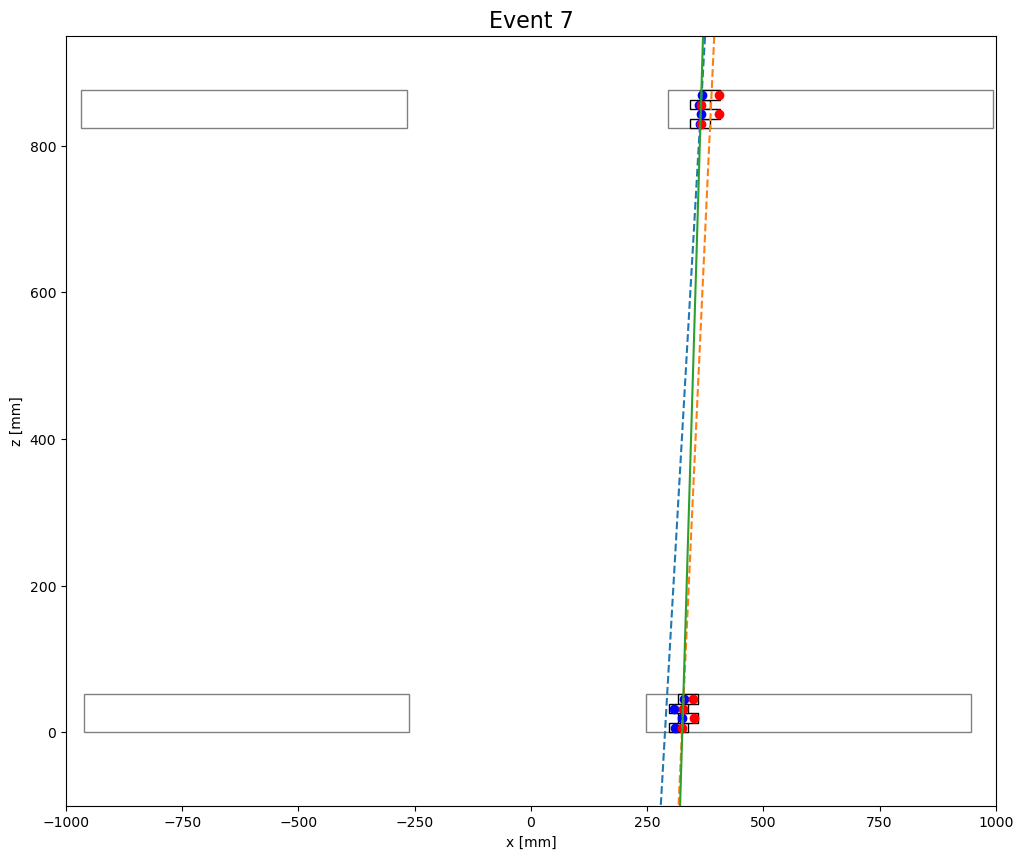

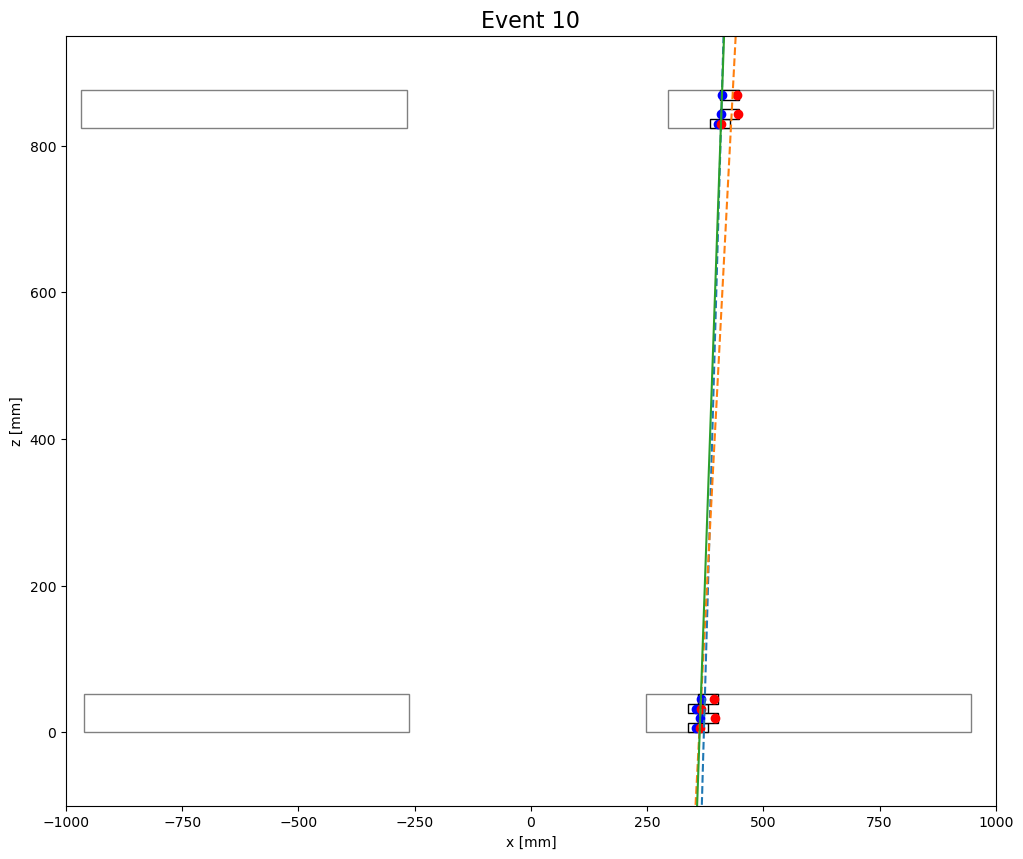

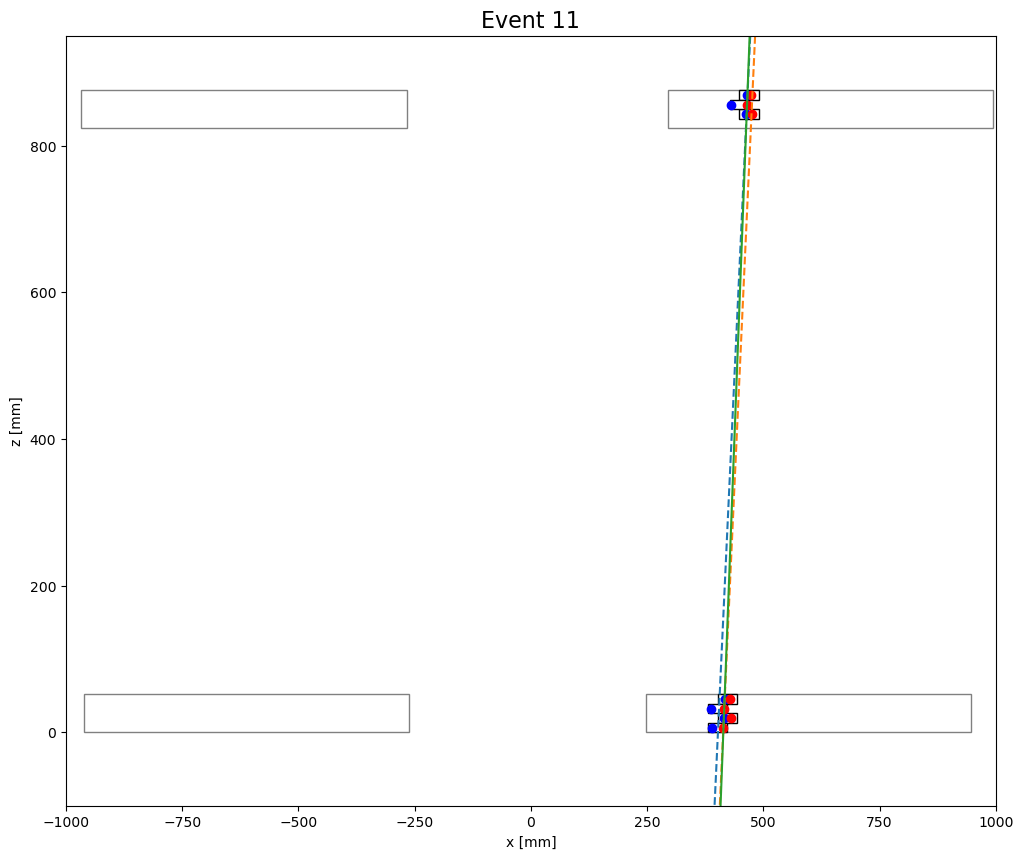

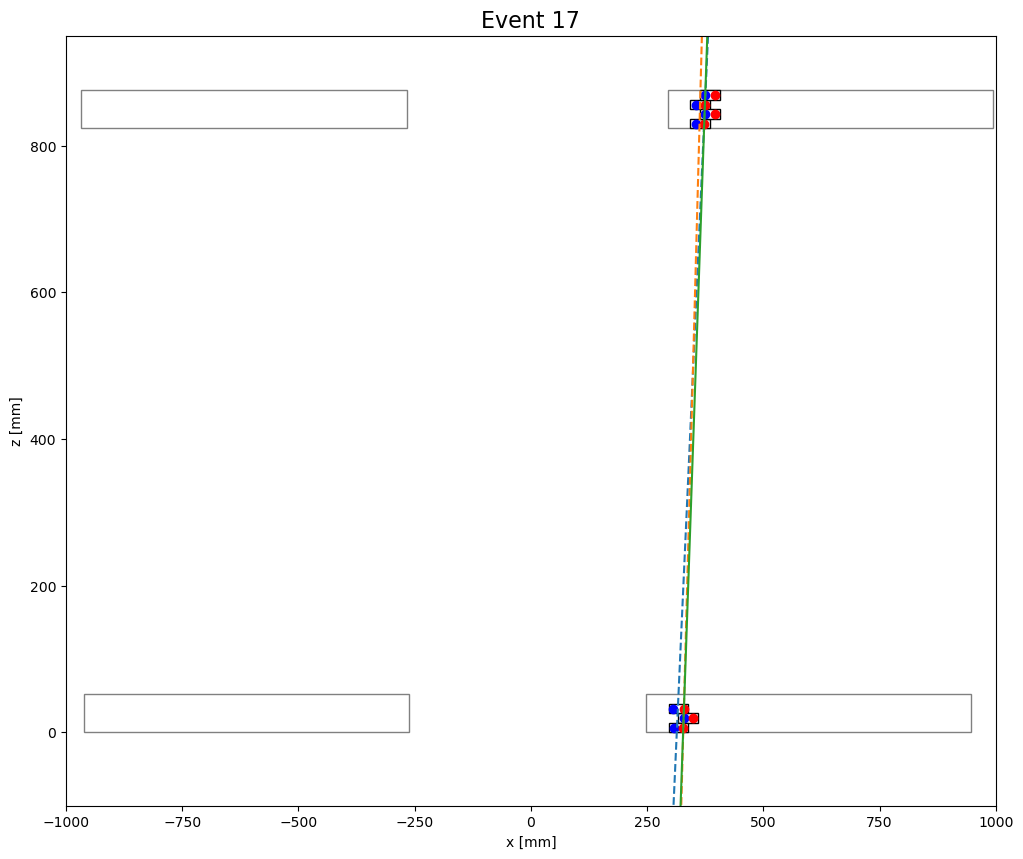

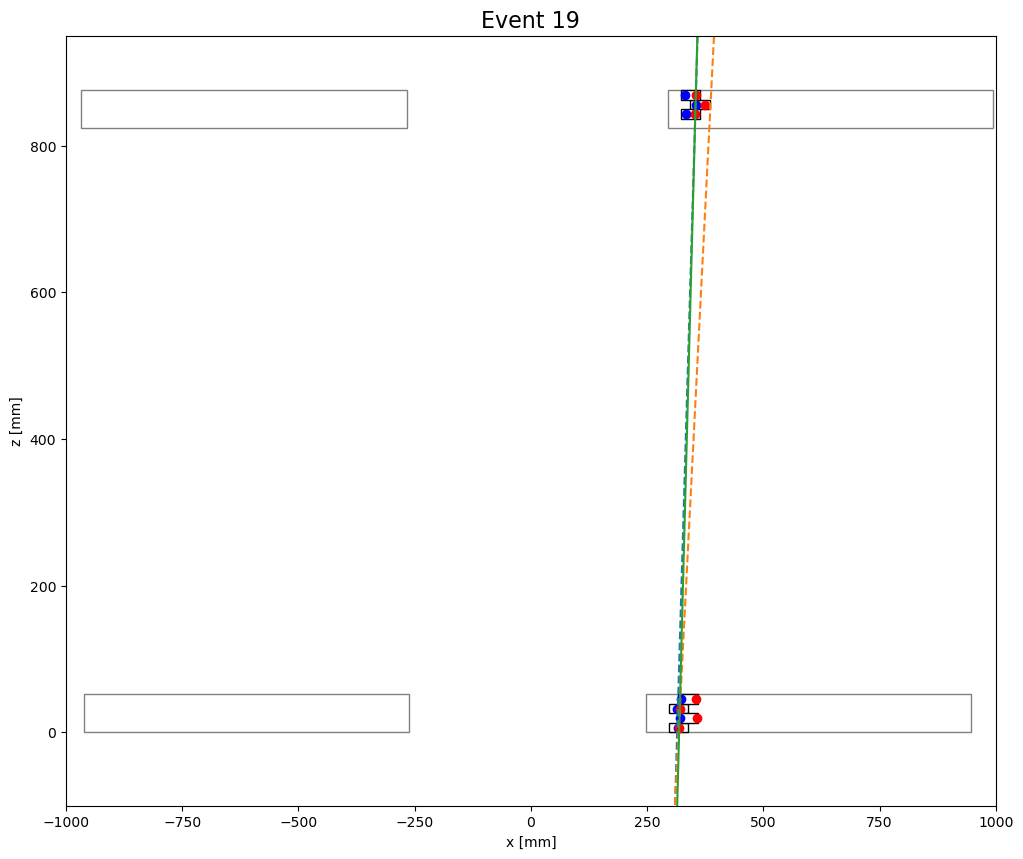

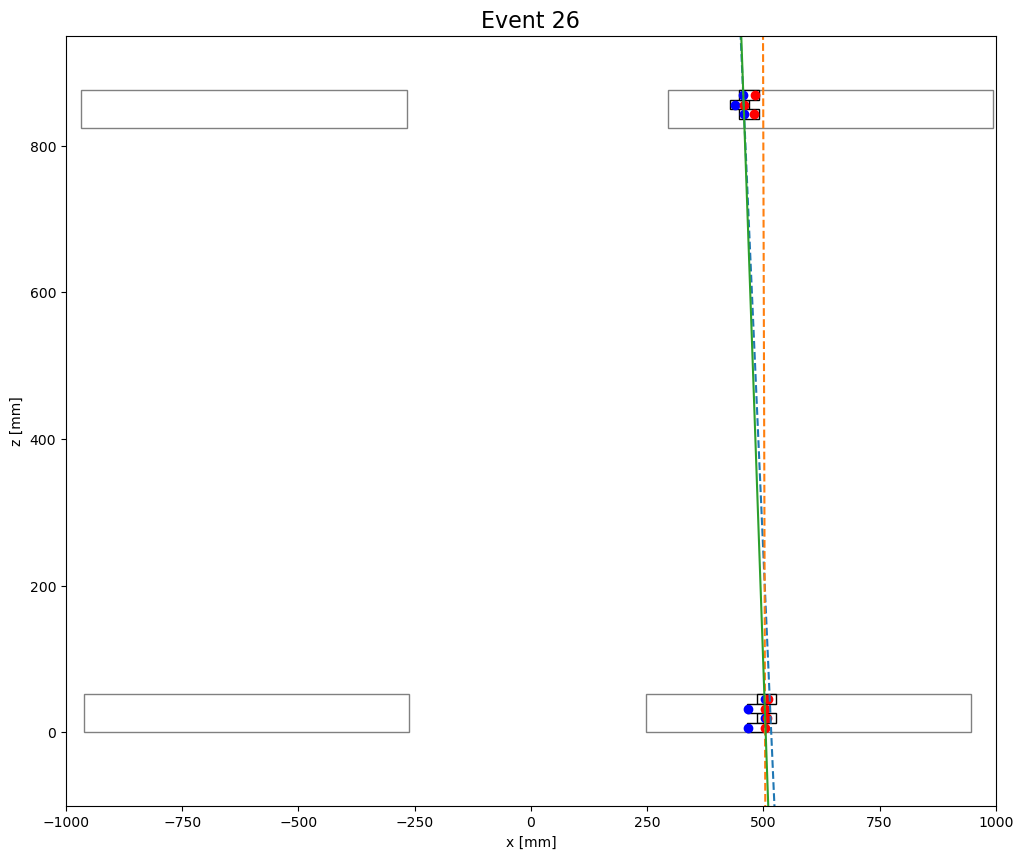

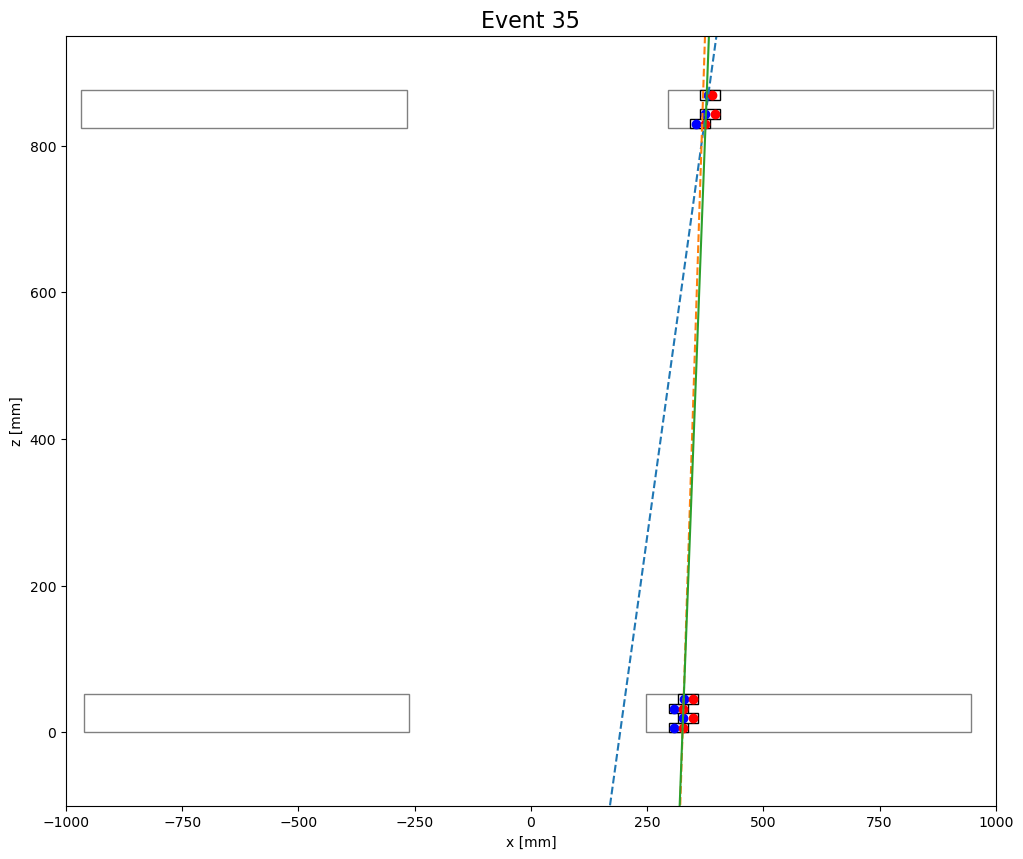

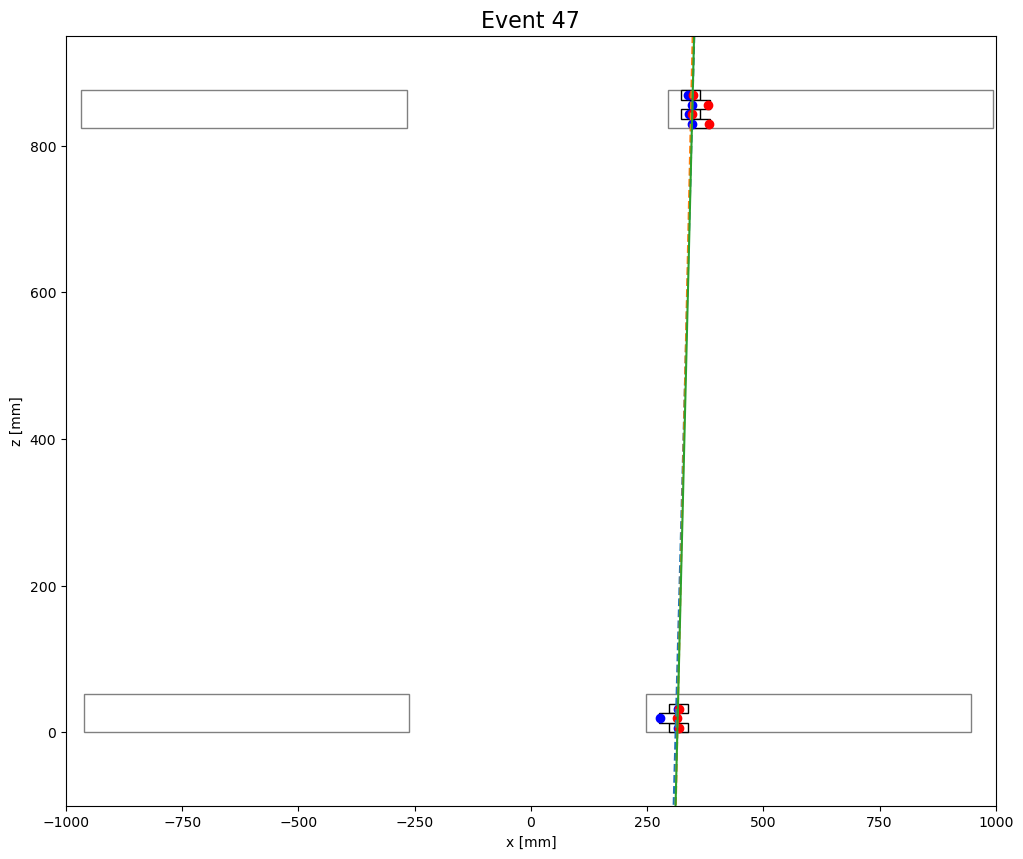

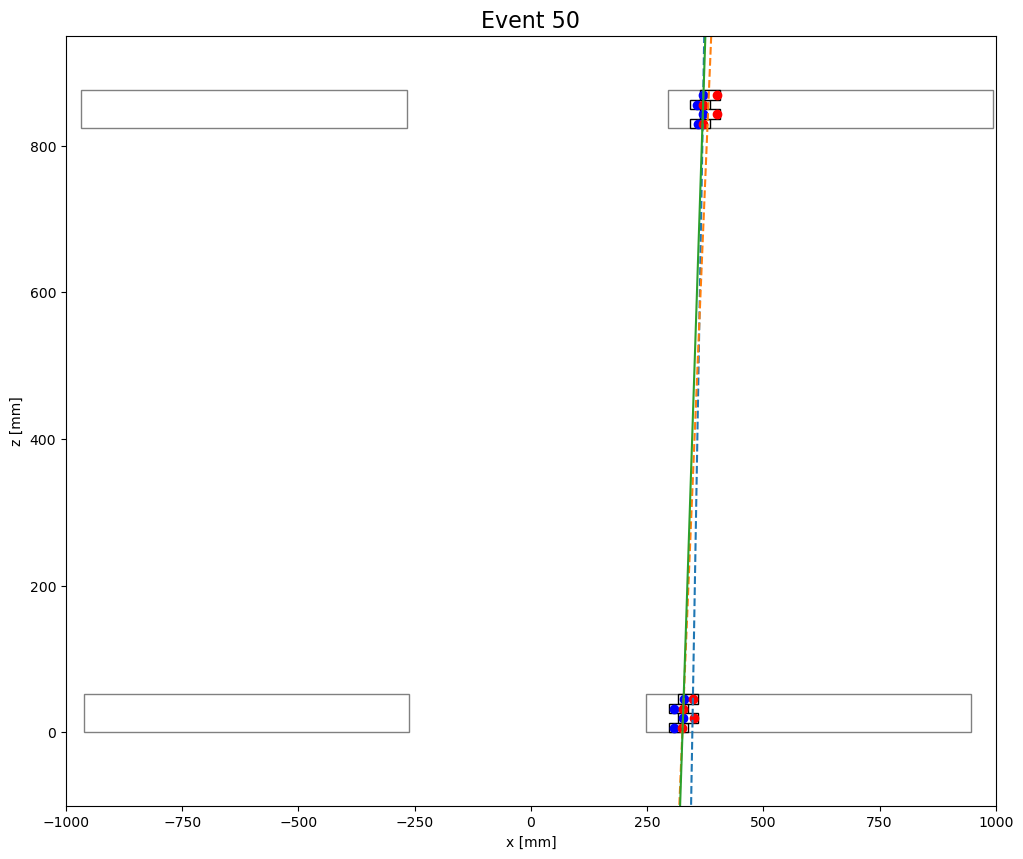

In [17]:
from matplotlib.patches import Rectangle
from scipy.stats import linregress

def event_plotter(event_number):
    my_event=cal1[event_number]
    x_centers, z_centers=(my_event['xlg']+my_event['xrg'])/2, my_event['zg']
    fig, ax=plt.subplots(figsize=(12,10))

    #drawing the detectors   
    for i in range(4):
        x_origs=np.array(global_x_shifts)-700
        z_origs=global_z_shifts
        detector=Rectangle([x_origs[i], z_origs[i]], 700, 4*ZCELL, edgecolor='gray', facecolor='white')
        ax.add_artist(detector)

    #drawing the triggered cells
    for i in range(len(my_event)):
        rect=Rectangle([x_centers[i]-XCELL/2, z_centers[i]-ZCELL/2], XCELL, ZCELL, edgecolor='black', facecolor='white')
        ax.add_artist(rect)

    ax.scatter(my_event['xlg'], my_event['zg'], color='blue')
    ax.scatter(my_event['xrg'], my_event['zg'], color='red')
    XRANGE=[-1000, 1000]
    YRANGE=[-100, 950]
    ax.set_xlim(XRANGE)
    ax.set_ylim(YRANGE)
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('z [mm]')
    ax.set_title(f'Event {event_number}', size=16)

    (xu,zu)=zip(*opt_track(my_event, calib_config[0]))
    (xd,zd)=zip(*opt_track(my_event, calib_config[1]))
    x=np.concatenate([xu,xd])
    z=np.concatenate([zu,zd])

    resu=linregress(zu,xu)
    resd=linregress(zd,xd)
    res=linregress(z,x)

    xspace=np.linspace(*XRANGE, 1000)
    ax.plot(xspace, 1/resu.slope*xspace-resu.intercept/resu.slope, '--')
    ax.plot(xspace, 1/resd.slope*xspace-resd.intercept/resd.slope, '--')
    ax.plot(xspace, 1/res.slope*xspace-res.intercept/res.slope)

    #ax.plot(xu,zu)
    #ax.plot(xd,zd)
    


    plt.show()
    my_event


for k in range(10):
    event_plotter(impeccable_events[k])
#event_plotter(4)

### Let's observe that the eighth hit of 51-th event of first calibration run (so maybe other ones too) not only presents xleft and xright farther apart than the width of a cell, but neither of the two isn't compatible with a fitting line for the trajectory

In [ ]:
event=cal1[1]
print(opt_track(event, 3))

[(-290.01, 6.5), (-283.47, 19.5), (-272.83, 45.5)]


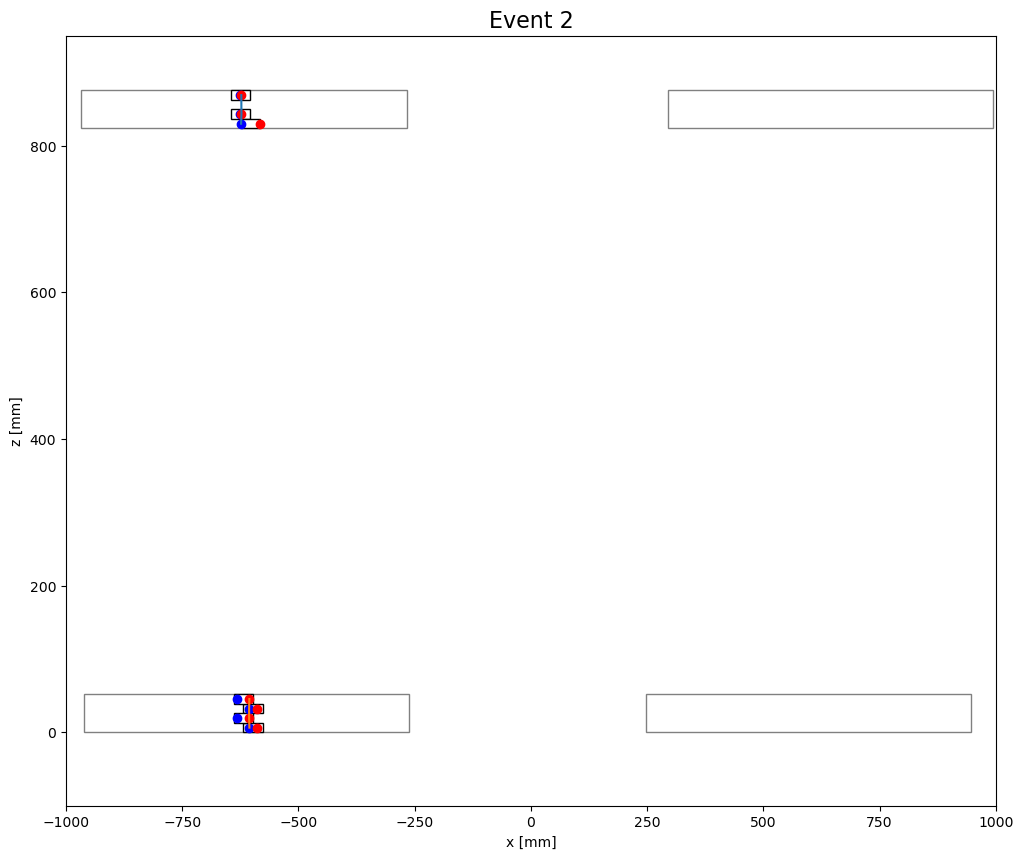

In [ ]:
event_plotter(impeccable_events[0])